# 1. Imports & Installation

In [1]:
%%capture
!pip install wandb --upgrade

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import image

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms

import tqdm.notebook as tqdm

import wandb # wandb is used to monitor the network during training and evaluation

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Defining the pipeline

In [5]:
# The whole pipeline
def model_pipeline(hyperparameters):
    
    with wandb.init(project="pytorch-pipeline",config=hyperparameters):

        config = wandb.config # We access hyperparameters through wandb so logging matches execution

        model, train_loader, test_loader, criterion, optimizer = make(config)
        print(model)

        train(model, train_loader, test_loader , criterion, optimizer, config) # Evaluate the model at a given frequency

    return model

In [6]:
# Initialise the model and it's parameters
def make(config):

    # Make the data
    train = get_data(train_bool=True)
    test = get_data(train_bool=False)

    train_loader = make_loader(train, batch_size = config.batch_size)
    test_loader = make_loader(test, batch_size = config.batch_size)

    # Make the model
    model = Network(config.kernels,config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss() #combine logsoftmax and nlloss
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, train_loader, test_loader, criterion, optimizer

In [7]:
# Download the dataset
def get_data(train_bool=True):
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5),(0.5))
                                    ])
    
    dataset = datasets.MNIST(root='data/',
                             download=True,
                             train=train_bool,
                             transform=transform)
    return dataset

In [8]:
# Make the loader
def make_loader(dataset,batch_size):
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
    return loader

# 3. Defining the CNN

In [36]:
class ConvBlock(nn.Module):
    def __init__(self,nb_in,nb_out):
        super(ConvBlock,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=nb_in,out_channels=nb_out,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(nb_out),
            nn.MaxPool2d(kernel_size=2)
            #nn.Dropout2d() # The dropout will cause a lower training accuracy
        )

    def forward(self, x):
        return self.block(x)

In [35]:
class FullyConnectedBlock(nn.Module):
    def __init__(self,nbInput,nbClasses):
        super(FullyConnectedBlock,self).__init__()
        self.block = nn.Sequential(
            nn.Linear(nbInput,nbClasses)
            #nn.Dropout()
        )
    
    def forward(self, x):
        return self.block(x)

In [34]:
"""
class Network(nn.Module):

    def __init__(self, kernels, nb_classes=10):
        super(Network,self).__init__()
        layers=[]
        layers.append(ConvBlock(1,kernels[0])) # 28*28*1 -> 14*14*16
        layers.append(ConvBlock(kernels[0],kernels[1])) # 14*14*16 -> 7*7*32
        layers.append(ConvBlock(kernels[1],kernels[2])) # 7*7*32 -> 3*3*64
        layers.append(nn.Flatten()) # 576
        layers.append(FullyConnectedBlock(3*3*kernels[-1],nb_classes))
 
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


~One other way to do create the network~"""

class Network(nn.Module):
    def __init__(self, kernels, nb_classes=10):
        super(Network,self).__init__()
        
        self.conv1 = ConvBlock(1,kernels[0]) # 28*28*1 -> 14*14*16
        self.conv2 = ConvBlock(kernels[0],kernels[1]) # 14*14*16 -> 7*7*32
        self.conv3 = ConvBlock(kernels[1],kernels[2]) # 7*7*32 -> 3*3*64
        self.flatten = nn.Flatten() # 576
        self.fclayer = FullyConnectedBlock(3*3*kernels[-1],nb_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        x = self.fclayer(x)

        return x

# 4. Defining the training and test phase

In [20]:
# Train the model and test it at a given frequency
def train(model, train_loader, test_loader ,criterion, optimizer, config):

    # Tell wandb to watch the model parameters (gradients,  weights, ...)
    wandb.watch(model,criterion,log="all",log_freq=10) #log_freq in number of steps

    nb_epochs = config.epochs
    

    for epoch in range(1,nb_epochs+1): 
        model.train() # Set the model to train mode (impact the dropout and batchnorm2d layers)

        progressB = tqdm.tqdm(enumerate(train_loader),total=len(train_loader)) # tqdm iterator -> show a progress bar

        totalCorrect=0 # Keep the number of correct answers to compute the training accuracy
        total=0

        for step,(images,labels) in progressB:

            batchCorrect,loss = train_batch(images,labels,model,optimizer,criterion)

            totalCorrect+=batchCorrect # batchCorrect is the number of correct answers in the given batch
            total+=len(labels) # Adding the batch size

            accuracy = 100*(totalCorrect/total)   

            wandb.log({'Train Loss': loss, 'Train Accuracy': accuracy, 'Epoch': epoch})
            progressB.set_description(f'loss: {loss.item():.2f}, accuracy: {accuracy:.2f},epoch: {epoch}/{nb_epochs}')

        # Test the model after each epoch if config.test_frequency=1
        if(epoch%config.test_frequency==0):
            test(model,test_loader,config)

In [13]:
# Train the model for a single batch, and update the model's parameters
def train_batch(images,labels,model,optimizer,criterion):
    images = images.to(device)
    labels = labels.to(device)

    # Forward propagation
    outputs = model(images)

    # Calculate softmax and cross entropy loss
    loss = criterion(outputs,labels)

    # Clear gradient
    optimizer.zero_grad()
    # Calculating gradient
    loss.backward()
    # Update parameters
    optimizer.step()

    # Compute accuracy for the batch
    _,predicted = torch.max(outputs.detach(),1) 
    nb_correct = (predicted==labels).sum().item() # .item() to get the tensor value

    return nb_correct,loss

In [24]:
# Test the model and save it to the onnx and pt format
def test(model, test_loader,config):
    model.eval()
    correct = 0
    total = 0

    progressB = tqdm.tqdm(enumerate(test_loader),total=len(test_loader))

    with torch.no_grad(): # All the operations whill have no gradient
        for _,(images,labels) in progressB:

            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _,predicted = torch.max(outputs.detach(),1) 

            total+=labels.size(0)
            correct+=(predicted == labels).sum().item() 

        accuracy = 100*(correct/total)
        wandb.log({'Test Accuracy': accuracy})

        print(f'Accuracy on test set: {accuracy:.2f}')

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model,images,config.model_onnx_path)
    wandb.save(config.model_onnx_path)

    # Save the model in the pytorch format
    torch.save(model.state_dict(),config.model_pt_path)
    wandb.save(config.model_pt_path)

# 5. Using the pipeline to train the model

In [18]:
# Contains the model and training configuration
config = dict(
    epochs=2, # Number of training epochs
    classes=10, # Number of classes
    kernels=[16,32,64], # Number of kernels in each convolution layer (16 kernels in the first conv layer in this example)
    batch_size=128, 
    learning_rate=0.001,
    dataset="MNIST",
    architecture="CNN",
    model_pt_path="./state_dict_model.pt", # The path of the model's state_dict (used to save and/or load it)
    model_onnx_path="./model.onnx", # The path of the model at the onnx format (used to save it)
    test_frequency=1 # Test the model each test_frequency epoch (here, the model is tested at the end of each epoch)
)

In [41]:
model = model_pipeline(config)

Network(
  (conv1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fl


Accuracy on test set: 98.83



Accuracy on test set: 98.93


Train Loss,0.04777
Train Accuracy,99.11167
Epoch,2
_runtime,75
_timestamp,1613928925
_step,939
Test Accuracy,98.93


Train Loss,█▃▂▂▂▂▁▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
Train Accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁█


# 6. Bonus : See activation map

In [42]:
def load_model(config):
    model = Network(config['kernels'],config['classes']).to(device)
    model.load_state_dict(torch.load(config['model_pt_path']))
    model.eval()
    return model

def get_activation(name,activation):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [43]:
def get_activation_map(model,layer_name,image):

    activation={}
    for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name,activation))

    output = model(image[None,...]).float().to(device)
    activ_map = activation[layer_name].detach()
    activ_map = torchvision.utils.make_grid(activ_map)
    activ_map = activ_map.cpu().numpy()

    fig = plt.figure()
    for i in range(activ_map.shape[0]):
        fig.add_subplot(np.round(np.sqrt(activ_map.shape[0])),np.round(np.sqrt(activ_map.shape[0])),i+1)
        plt.imshow(activ_map[i])


    plt.show()
    plt.imshow(image.detach().cpu().reshape((28,28)),cmap='gray')

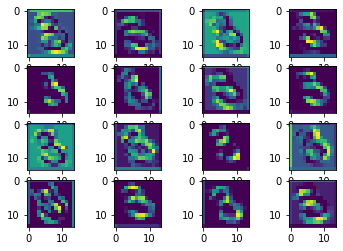

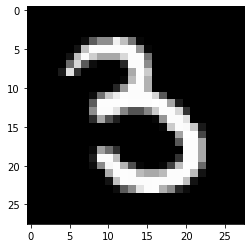

In [44]:
test_loader = make_loader(get_data(False), batch_size = config['batch_size'])

images, labels = next(iter(test_loader))
images, labels = images.cuda(), labels.cuda()
image = images[0]

model = load_model(config)

get_activation_map(model,'conv1',image)